### CONFIGURATION

In [11]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
from cellpose import models, io
from glob import glob
import config

# --- CONFIGURATION ---
# 1. Path to your 4x images
INPUT_ROOT = os.path.join(config.DATASPACE, "downsampled_4x")

CACHE_PATH = os.path.join(config.DATASPACE, "cellpose_cache")
os.makedirs(CACHE_PATH, exist_ok=True)
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = CACHE_PATH

# 2. Now import cellpose (It will see the variable and use the new path)
from cellpose import models, io

print(f"Cellpose will save models to: {os.environ['CELLPOSE_LOCAL_MODELS_PATH']}")

# 2. Pick a Core to test (Change "Core_01" to any core you want to check)
TEST_CORE = "Core_11" 
CK_INDEX = 6  # The Cytokeratin channel index

# 3. TUNING PARAMETERS (The knobs you want to turn)
# 'cyto2' is usually best for cytoplasm/tissue sheets. 
# 'nuclei' is for nuclei.
MODEL_TYPE = 'nuclei' 

DIAMETER = 20
# 3. LOWER FLOW THRESHOLD (The "Messy" Permitter)
# 0.4 is standard. 0.8 allows for "weird" non-circular shapes.
# Since a web is VERY weird, we max this out.
FLOW_THRESHOLD = 0.9

# 4. NEGATIVE CELL PROBABILITY (The "Sensitivity" Booster)
# Default is 0.0. Setting to -1.0 or -2.0 forces it to keep faint signals.
CELLPROB_THRESHOLD = -2.0 

# 5. REMOVE MIN SIZE
# Don't let it delete small bits of the web.
MIN_SIZE = 10

Cellpose will save models to: /data3/junming/3D-TMA-Register/cellpose_cache


### 1. Load the Image

Loading: /data3/junming/3D-TMA-Register/downsampled_4x/Core_11/240919_3D_BL_TMA_1_Core11.ome.tif
Image Shape: (1512, 1512)
Data Type: uint16 (Max Value: 533)


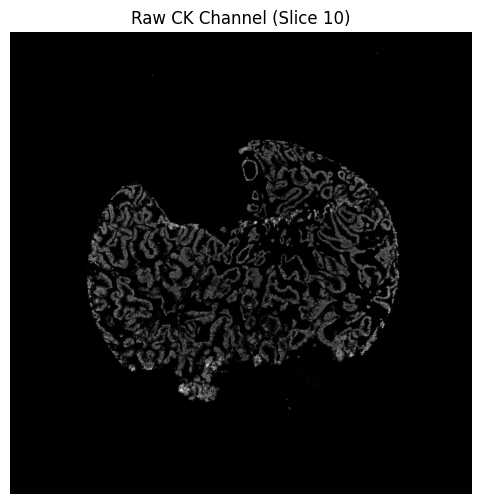

In [12]:
# Find the middle slice of the test core
core_folder = os.path.join(INPUT_ROOT, TEST_CORE)
slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))

if not slice_files:
    print(f"Error: No images found in {core_folder}")
else:
    # Pick middle slice
    mid_idx = len(slice_files) // 2
    test_file = slice_files[mid_idx]
    print(f"Loading: {test_file}")

    # Load
    img = tifffile.imread(test_file)
    
    # Extract CK Channel
    if img.shape[0] < 20: 
        ck = img[CK_INDEX, :, :]
    else: 
        ck = img[:, :, CK_INDEX]
    
    print(f"Image Shape: {ck.shape}")
    print(f"Data Type: {ck.dtype} (Max Value: {ck.max()})")

    # Normalize for display
    ck_vis = cv2.normalize(ck, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(ck_vis, cmap='gray')
    plt.title(f"Raw CK Channel (Slice {mid_idx})")
    plt.axis('off')
    plt.show()

### 2. Run Cellpose Inference

In [13]:
print(f"Initializing Cellpose model: {MODEL_TYPE}...")
# Use CellposeModel directly
model = models.CellposeModel(gpu=True, model_type=MODEL_TYPE)

print(f"Running Inference (Diameter={DIAMETER})...")

# FIX: Unpack only 3 values (masks, flows, styles)
masks, flows, styles = model.eval(
    ck, 
    diameter=DIAMETER, 
    channels=[0,0], # Grayscale
    flow_threshold=FLOW_THRESHOLD,
    cellprob_threshold=CELLPROB_THRESHOLD,
    min_size=MIN_SIZE
)

print(f"Done. Found {len(np.unique(masks)) - 1} regions.")

model_type argument is not used in v4.0.1+. Ignoring this argument...


Initializing Cellpose model: nuclei...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Running Inference (Diameter=20)...
Done. Found 2222 regions.


### 3. Visualize Prediction

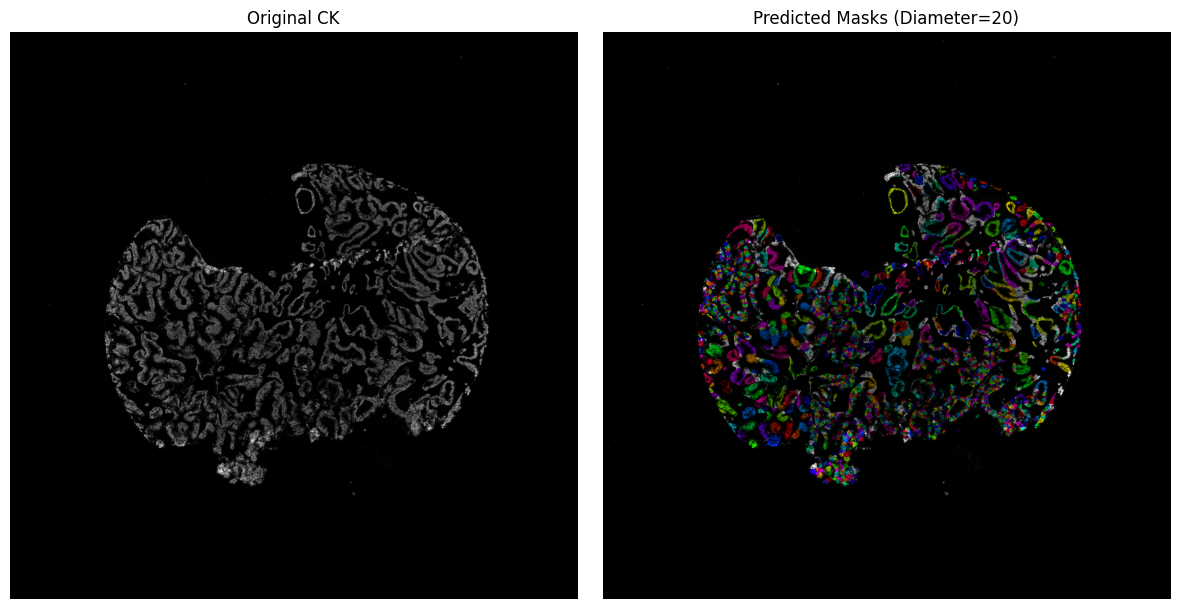

In [14]:
from cellpose import plot

fig = plt.figure(figsize=(12, 6))

# Plot Original
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(ck_vis, cmap='gray')
ax1.set_title("Original CK")
ax1.axis('off')

# Plot Masks
# Cellpose has a helper to create random colors for masks
mask_overlay = plot.mask_overlay(ck_vis, masks)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(mask_overlay)
ax2.set_title(f"Predicted Masks (Diameter={DIAMETER})")
ax2.axis('off')

plt.tight_layout()
plt.show()

Loading 20 slices for Core_11...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Volume loaded successfully. Shape: (20, 1512, 1512)
Running Cellpose extraction...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
channels deprecated

Extracted 14487 candidate holes.
Found 210 valid landmarks.


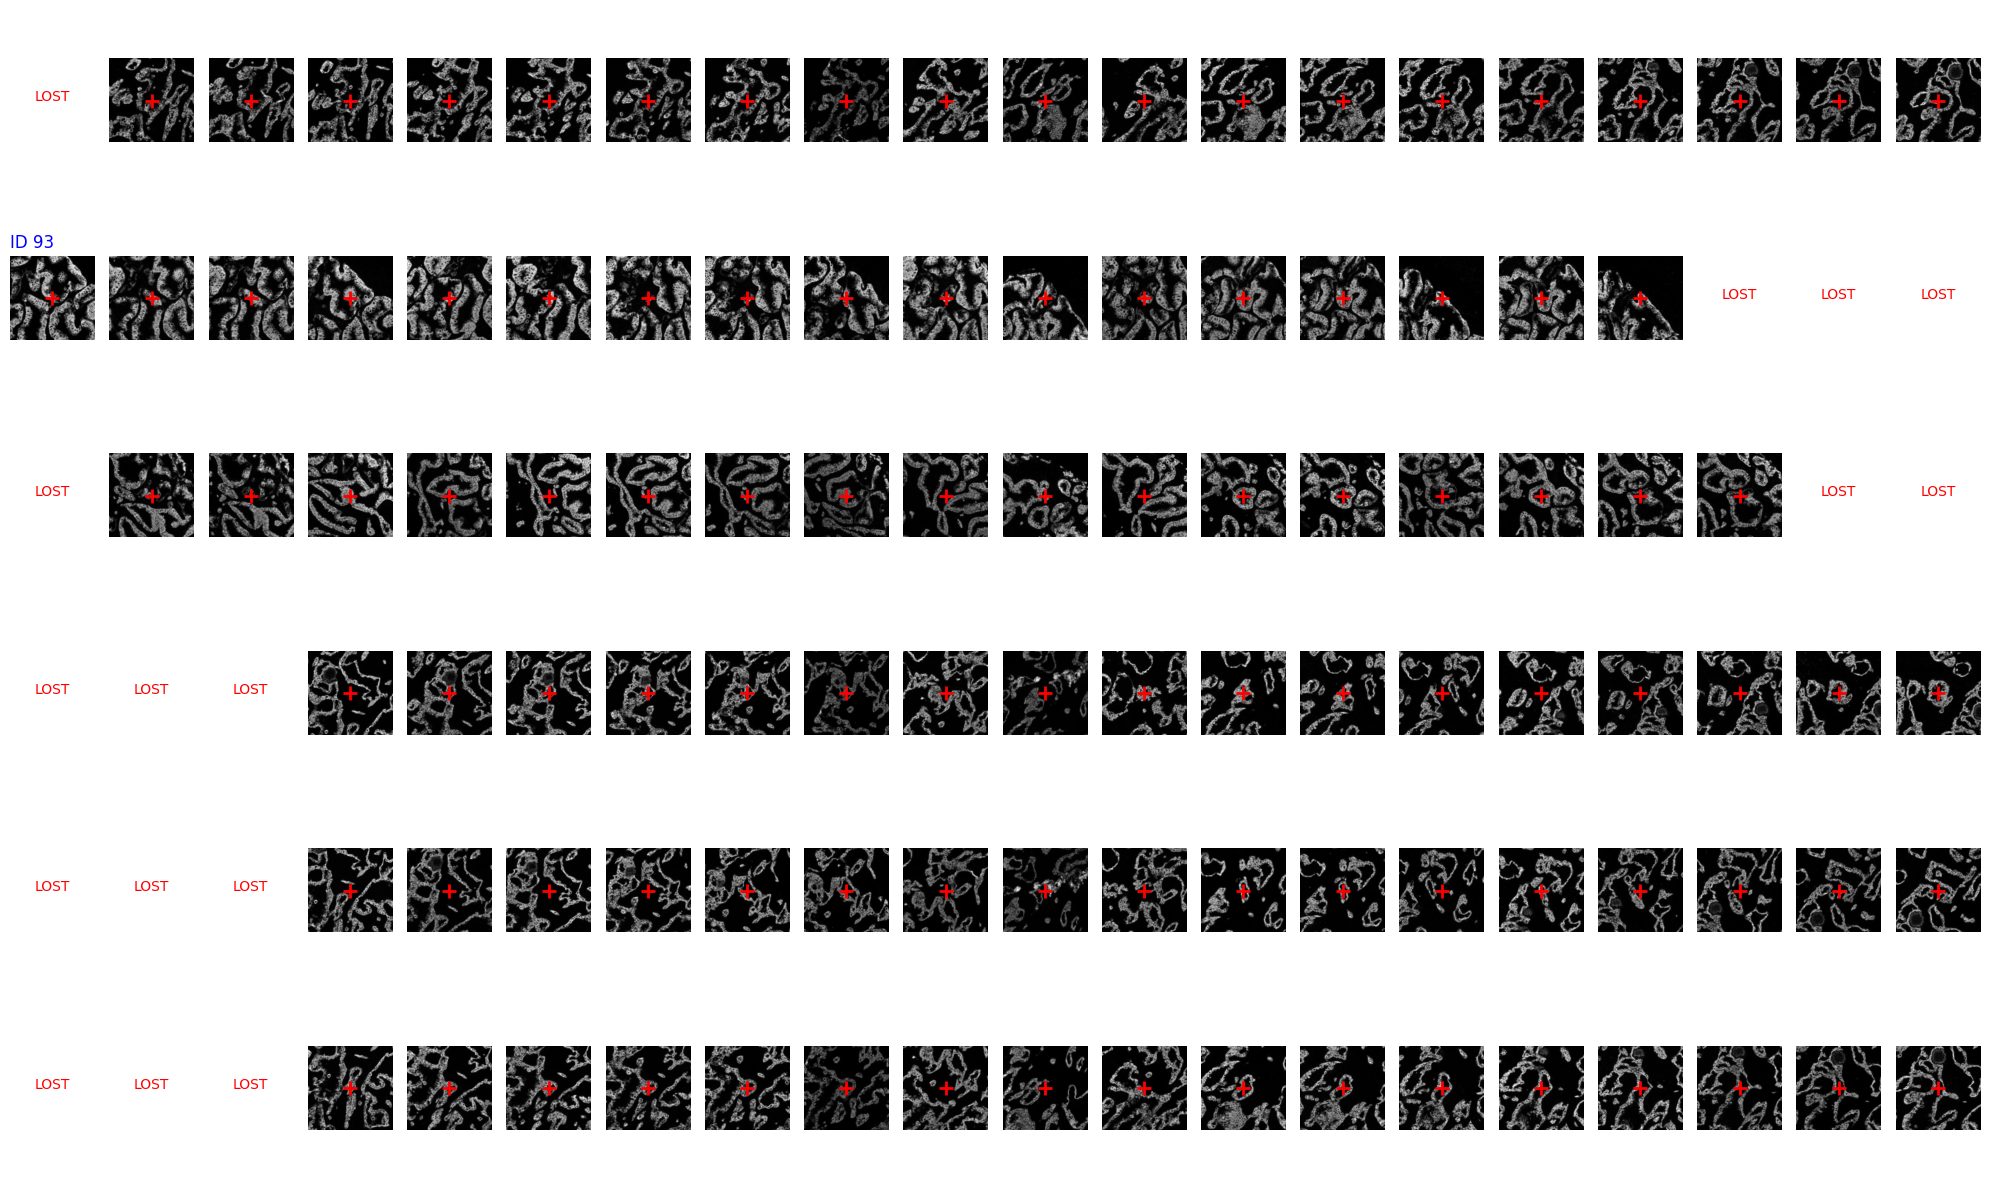

In [16]:
import numpy as np
import pandas as pd
import cv2
import tifffile
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from skimage.measure import regionprops
from glob import glob
import os

# --- 1. CONFIGURATION ---
TEST_CORE = "Core_11"   # Make sure this matches your folder name
CK_INDEX = 6            # Channel index for Cytokeratin

# Cellpose Params
DIAMETER = 30 
FLOW_THRESHOLD = 0.9
CELLPROB_THRESHOLD = -1.0

# Landmark Params (tuned for your "jumping" data)
MIN_AREA = 100          # Min pixel area for a hole
MAX_AREA = 3000         # Max pixel area
MAX_DRIFT = 200         # Allow jumps up to 200px (handles the drift)
MIN_STABILITY = 0.4     # Landmark must exist in only 40% of slices to be kept

# --- 2. ROBUST LOADER (Defines 'volume') ---
def load_volume(core_id):
    core_folder = os.path.join(INPUT_ROOT, core_id)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    
    if not slice_files:
        print(f"No files found for {core_id}")
        return None

    # Load raw
    raw_stack = []
    print(f"Loading {len(slice_files)} slices for {core_id}...")
    for fpath in slice_files:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        raw_stack.append(ck)
        
    # Resize to middle slice shape (Fixes "inhomogeneous shape" error)
    mid_idx = len(raw_stack) // 2
    ref_h, ref_w = raw_stack[mid_idx].shape
    
    clean_stack = []
    for slice_img in raw_stack:
        if slice_img.shape != (ref_h, ref_w):
            resized = cv2.resize(slice_img, (ref_w, ref_h), interpolation=cv2.INTER_CUBIC)
            clean_stack.append(resized)
        else:
            clean_stack.append(slice_img)
            
    return np.array(clean_stack)

# EXECUTE LOAD
volume = load_volume(TEST_CORE)
print(f"Volume loaded successfully. Shape: {volume.shape}")


# --- 3. EXTRACT CANDIDATES (Batch Cellpose) ---
all_candidates = []
print("Running Cellpose extraction...")

for z in range(volume.shape[0]):
    img_slice = volume[z, :, :]
    masks, _, _ = model.eval(img_slice, diameter=DIAMETER, channels=[0,0],
                             flow_threshold=FLOW_THRESHOLD, cellprob_threshold=CELLPROB_THRESHOLD)
    
    for p in regionprops(masks):
        if MIN_AREA < p.area < MAX_AREA:
            y, x = p.centroid
            all_candidates.append({'z': z, 'y': y, 'x': x, 'id': p.label, 'area': p.area})

df = pd.DataFrame(all_candidates)
print(f"Extracted {len(df)} candidate holes.")


# --- 4. LINK & FILTER ---
df['chain_id'] = -1 
next_chain_id = 0

for z in range(volume.shape[0] - 1):
    c_slice = df[df['z'] == z]
    n_slice = df[df['z'] == z + 1]
    
    if c_slice.empty or n_slice.empty: continue
        
    dists = cdist(c_slice[['y', 'x']].values, n_slice[['y', 'x']].values)
    min_dists = dists.min(axis=1)
    match_indices = dists.argmin(axis=1)
    
    for i, (dist, match_idx) in enumerate(zip(min_dists, match_indices)):
        if dist < MAX_DRIFT:
            curr_idx = c_slice.index[i]
            next_idx = n_slice.index[match_idx]
            
            existing_id = df.loc[curr_idx, 'chain_id']
            if existing_id == -1:
                existing_id = next_chain_id
                df.loc[curr_idx, 'chain_id'] = existing_id
                next_chain_id += 1
            df.loc[next_idx, 'chain_id'] = existing_id

# Filter for stability
chain_counts = df[df['chain_id'] != -1]['chain_id'].value_counts()
robust_chains = chain_counts[chain_counts >= (volume.shape[0] * MIN_STABILITY)].index
print(f"Found {len(robust_chains)} valid landmarks.")


# --- 5. VISUALIZATION ---
top_chains = robust_chains[:6] 
CROP = 80

if len(top_chains) > 0:
    fig, axes = plt.subplots(len(top_chains), volume.shape[0], 
                             figsize=(20, 2 * len(top_chains)), squeeze=False)

    for i, chain_id in enumerate(top_chains):
        chain_data = df[df['chain_id'] == chain_id].set_index('z')
        for z in range(volume.shape[0]):
            ax = axes[i, z]
            ax.axis('off')
            if z in chain_data.index:
                cx, cy = int(chain_data.loc[z, 'x']), int(chain_data.loc[z, 'y'])
                # Safe crop
                y1, y2 = max(0, cy-CROP), min(volume.shape[1], cy+CROP)
                x1, x2 = max(0, cx-CROP), min(volume.shape[2], cx+CROP)
                
                if y2 > y1 and x2 > x1:
                    ax.imshow(volume[z, y1:y2, x1:x2], cmap='gray')
                    ax.plot(cx - x1, cy - y1, 'r+', markersize=10, markeredgewidth=2)
                if z == 0: ax.set_title(f"ID {chain_id}", fontsize=12, color='blue', loc='left')
            else:
                ax.text(0.5, 0.5, "LOST", ha='center', color='red')
    plt.tight_layout()
    plt.show()
else:
    print("No landmarks found. Try increasing MAX_DRIFT.")

### template matching

Loading 20 slices for Core_10...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Volume Shape: (20, 1512, 1512) (Type: uint8)
Segmenting Anchor Slice (Z=10)...
Selecting templates from 384 candidates...
Tracking 8 templates across 20 slices...
Tracking complete. Showing top 5 consistent lumens.


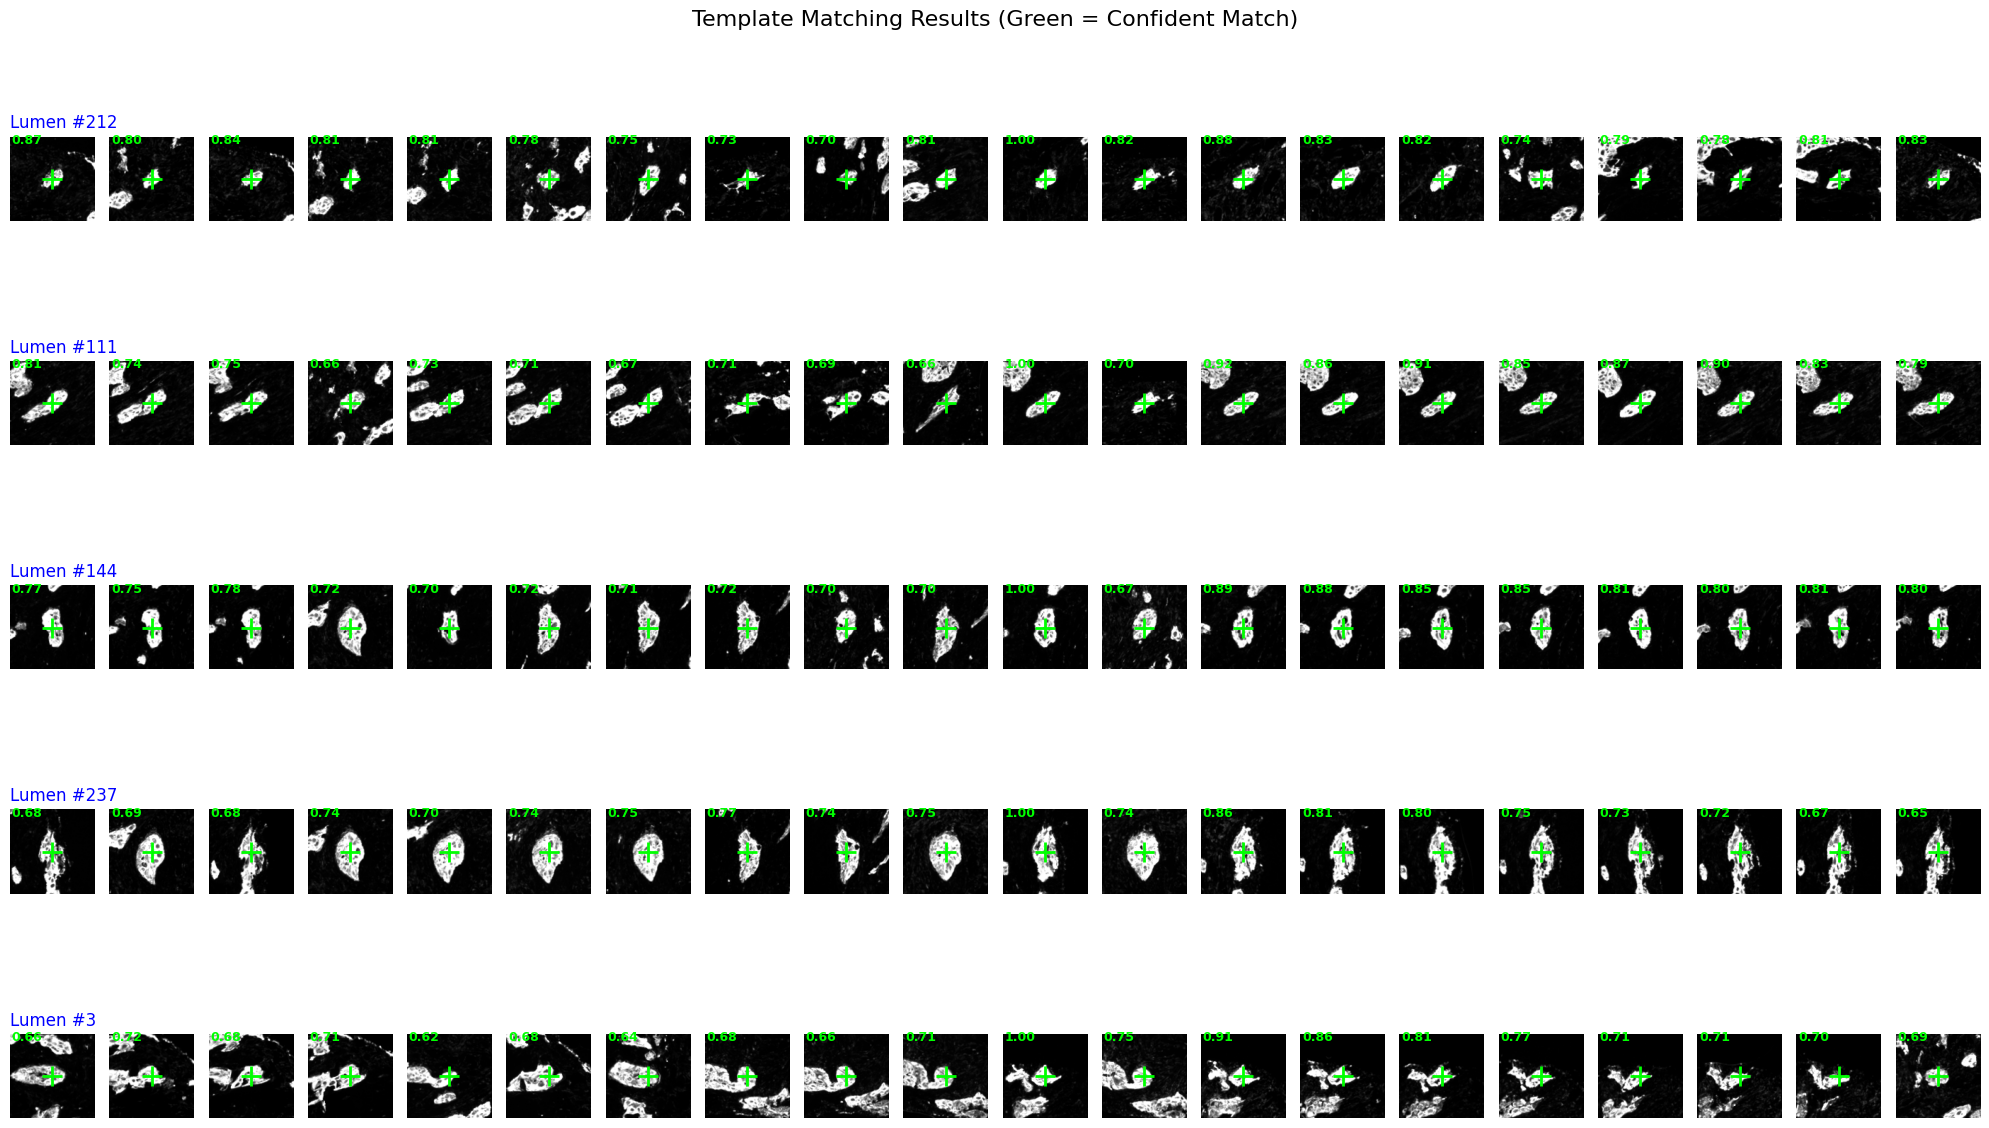

In [18]:
import numpy as np
import cv2
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from glob import glob
import os

# --- CONFIGURATION ---
TEST_CORE = "Core_10" 
CK_INDEX = 6
DIAMETER = 30 
MIN_AREA = 100
MAX_AREA = 4000
TEMPLATE_PADDING = 15 # Slightly larger context for better matching

# --- 1. ROBUST LOAD & NORMALIZE (Fixes the OpenCV Error) ---
def load_volume(core_id):
    core_folder = os.path.join(INPUT_ROOT, core_id)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None

    raw_stack = []
    print(f"Loading {len(slice_files)} slices for {core_id}...")
    
    for fpath in slice_files:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # --- CRITICAL FIX: CONVERT TO 8-BIT ---
        # OpenCV matchTemplate crashes on uint16. We must normalize to uint8.
        if ck.dtype != np.uint8:
            # Robust min/max scaling
            p1, p99 = np.percentile(ck, (1, 99))
            ck = np.clip((ck - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
            ck = ck.astype(np.uint8)
            
        raw_stack.append(ck)
        
    # Resize to match middle slice (Fixes "inhomogeneous shape")
    mid_idx = len(raw_stack) // 2
    ref_h, ref_w = raw_stack[mid_idx].shape
    
    clean_stack = []
    for slice_img in raw_stack:
        if slice_img.shape != (ref_h, ref_w):
            resized = cv2.resize(slice_img, (ref_w, ref_h), interpolation=cv2.INTER_CUBIC)
            clean_stack.append(resized)
        else:
            clean_stack.append(slice_img)
            
    return np.array(clean_stack)

# Load
volume = load_volume(TEST_CORE)
print(f"Volume Shape: {volume.shape} (Type: {volume.dtype})")


# --- 2. FIND ANCHOR TEMPLATES (From Middle Slice) ---
mid_z = volume.shape[0] // 2
anchor_img = volume[mid_z, :, :]

print(f"Segmenting Anchor Slice (Z={mid_z})...")
masks, _, _ = model.eval(anchor_img, diameter=DIAMETER, channels=[0,0], 
                         flow_threshold=0.9, cellprob_threshold=-1.0)

# Pick Top 8 Best "Holes"
props = regionprops(masks)
valid_props = [p for p in props if MIN_AREA < p.area < MAX_AREA]
valid_props.sort(key=lambda x: x.area, reverse=True) 

templates = []
print(f"Selecting templates from {len(valid_props)} candidates...")

chosen_centers = []
for p in valid_props:
    if len(templates) >= 8: break
    
    y, x = p.centroid
    
    # Distance check (ensure spread out)
    if any(np.sqrt((y-cy)**2 + (x-cx)**2) < 60 for cy, cx in chosen_centers):
        continue
        
    # Extract Template with Padding
    minr, minc, maxr, maxc = p.bbox
    y1 = max(0, minr - TEMPLATE_PADDING)
    x1 = max(0, minc - TEMPLATE_PADDING)
    y2 = min(volume.shape[1], maxr + TEMPLATE_PADDING)
    x2 = min(volume.shape[2], maxc + TEMPLATE_PADDING)
    
    patch = anchor_img[y1:y2, x1:x2]
    
    templates.append({
        'id': p.label,
        'image': patch, # Now strictly uint8
        'orig_y': y,
        'orig_x': x,
        'h': patch.shape[0],
        'w': patch.shape[1]
    })
    chosen_centers.append((y, x))


# --- 3. RUN TRACKER (Template Matching) ---
print(f"Tracking {len(templates)} templates across {volume.shape[0]} slices...")

tracker_results = {t['id']: [] for t in templates}

for z in range(volume.shape[0]):
    search_img = volume[z, :, :]
    
    for t in templates:
        # Match
        res = cv2.matchTemplate(search_img, t['image'], cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        # max_loc is the top-left corner of the best match
        top_left = max_loc
        center_x = top_left[0] + t['w'] // 2
        center_y = top_left[1] + t['h'] // 2
        
        tracker_results[t['id']].append({
            'z': z,
            'x': center_x,
            'y': center_y,
            'score': max_val
        })

# --- 4. VISUALIZATION (Montage) ---
# Filter: Keep only tracks with high confidence (>0.5 average)
best_tracks = []
for tid, tracks in tracker_results.items():
    df_track = pd.DataFrame(tracks)
    if df_track['score'].mean() > 0.5: 
        best_tracks.append((tid, df_track))

# Sort by quality
best_tracks.sort(key=lambda x: x[1]['score'].mean(), reverse=True)
final_selection = best_tracks[:5] 

print(f"Tracking complete. Showing top {len(final_selection)} consistent lumens.")

if final_selection:
    CROP = 60
    # Create plot
    fig, axes = plt.subplots(len(final_selection), volume.shape[0], 
                             figsize=(20, 2.5 * len(final_selection)), squeeze=False)
    
    for i, (tid, df_track) in enumerate(final_selection):
        df_track = df_track.set_index('z')
        
        for z in range(volume.shape[0]):
            ax = axes[i, z]
            ax.axis('off')
            
            cx, cy = int(df_track.loc[z, 'x']), int(df_track.loc[z, 'y'])
            score = df_track.loc[z, 'score']
            
            # Color code: Green=Good, Red=Bad Match
            color = 'lime' if score > 0.6 else 'red'
            
            y1, y2 = max(0, cy-CROP), min(volume.shape[1], cy+CROP)
            x1, x2 = max(0, cx-CROP), min(volume.shape[2], cx+CROP)
            
            if y2 > y1 and x2 > x1:
                ax.imshow(volume[z, y1:y2, x1:x2], cmap='gray')
                
                # Crosshair
                ax.plot(cx-x1, cy-y1, '+', color=color, markersize=14, markeredgewidth=2)
                
                # Score text
                ax.text(2, 10, f"{score:.2f}", color=color, fontsize=9, fontweight='bold')
            
            if z == 0: ax.set_title(f"Lumen #{tid}", fontsize=12, color='blue', loc='left')

    plt.suptitle(f"Template Matching Results (Green = Confident Match)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No good matches found. The anchor templates might be too generic (e.g., just black space).")

### gated template matching

Loading 20 slices for Core_10...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Volume Shape: (20, 1512, 1512) (Type: uint8)
Segmenting Anchor Slice (Z=10)...
Selecting templates from 384 candidates...
Tracking 8 templates across 20 slices...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Matching (Search Radius: 100px)...
Running GATED Template Ma

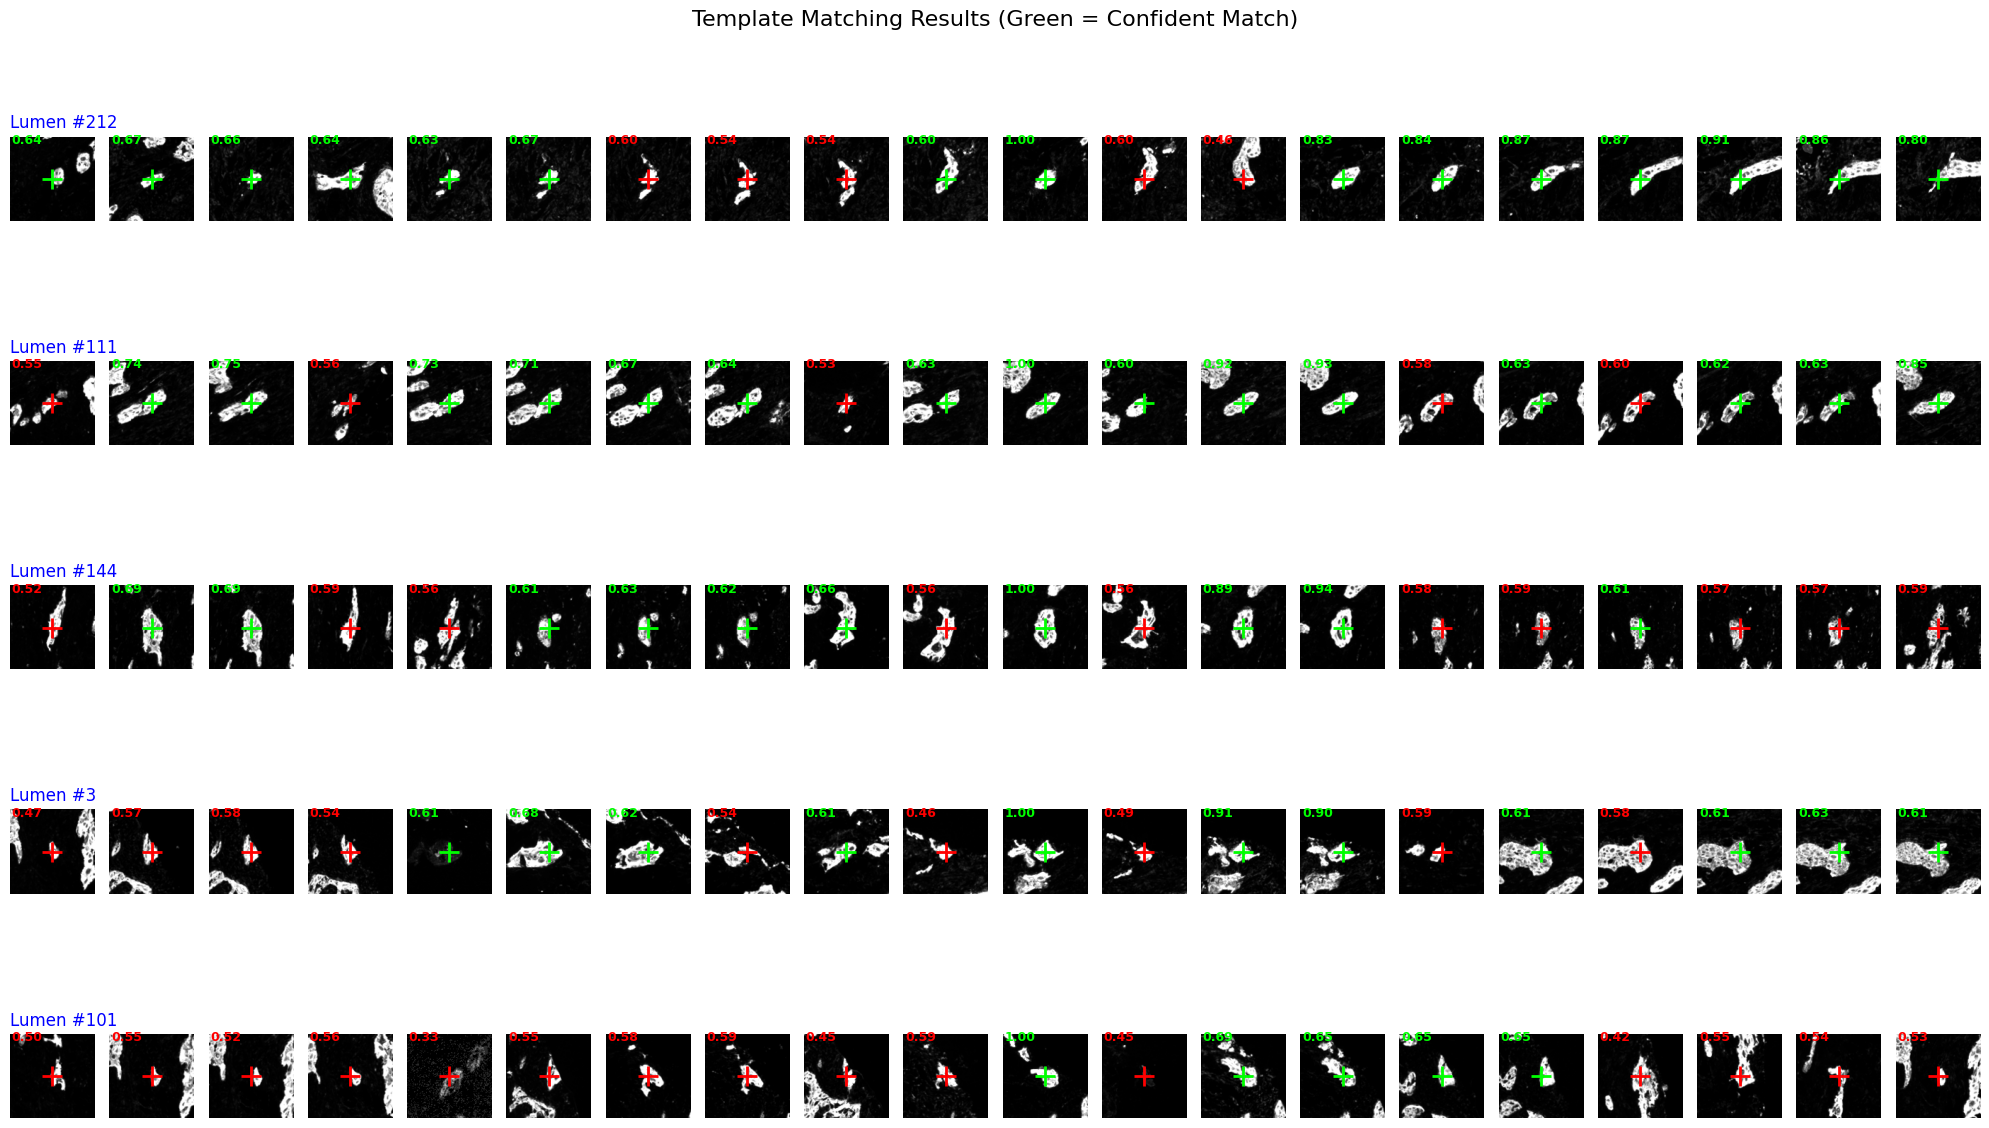

In [19]:
import numpy as np
import cv2
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from glob import glob
import os

# --- CONFIGURATION ---
TEST_CORE = "Core_10" 
CK_INDEX = 6
DIAMETER = 30 
MIN_AREA = 100
MAX_AREA = 4000
TEMPLATE_PADDING = 15 # Slightly larger context for better matching'ArithmeticError
SEARCH_RADIUS = 100   # Look +/- 100 pixels from the last position
UPDATE_THRESHOLD = 0.8 # Update template if match is super good

# --- 1. ROBUST LOAD & NORMALIZE (Fixes the OpenCV Error) ---
def load_volume(core_id):
    core_folder = os.path.join(INPUT_ROOT, core_id)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None

    raw_stack = []
    print(f"Loading {len(slice_files)} slices for {core_id}...")
    
    for fpath in slice_files:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # --- CRITICAL FIX: CONVERT TO 8-BIT ---
        # OpenCV matchTemplate crashes on uint16. We must normalize to uint8.
        if ck.dtype != np.uint8:
            # Robust min/max scaling
            p1, p99 = np.percentile(ck, (1, 99))
            ck = np.clip((ck - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
            ck = ck.astype(np.uint8)
            
        raw_stack.append(ck)
        
    # Resize to match middle slice (Fixes "inhomogeneous shape")
    mid_idx = len(raw_stack) // 2
    ref_h, ref_w = raw_stack[mid_idx].shape
    
    clean_stack = []
    for slice_img in raw_stack:
        if slice_img.shape != (ref_h, ref_w):
            resized = cv2.resize(slice_img, (ref_w, ref_h), interpolation=cv2.INTER_CUBIC)
            clean_stack.append(resized)
        else:
            clean_stack.append(slice_img)
            
    return np.array(clean_stack)

# Load
volume = load_volume(TEST_CORE)
print(f"Volume Shape: {volume.shape} (Type: {volume.dtype})")


# --- 2. FIND ANCHOR TEMPLATES (From Middle Slice) ---
mid_z = volume.shape[0] // 2
anchor_img = volume[mid_z, :, :]

print(f"Segmenting Anchor Slice (Z={mid_z})...")
masks, _, _ = model.eval(anchor_img, diameter=DIAMETER, channels=[0,0], 
                         flow_threshold=0.9, cellprob_threshold=-1.0)

# Pick Top 8 Best "Holes"
props = regionprops(masks)
valid_props = [p for p in props if MIN_AREA < p.area < MAX_AREA]
valid_props.sort(key=lambda x: x.area, reverse=True) 

templates = []
print(f"Selecting templates from {len(valid_props)} candidates...")

chosen_centers = []
for p in valid_props:
    if len(templates) >= 8: break
    
    y, x = p.centroid
    
    # Distance check (ensure spread out)
    if any(np.sqrt((y-cy)**2 + (x-cx)**2) < 60 for cy, cx in chosen_centers):
        continue
        
    # Extract Template with Padding
    minr, minc, maxr, maxc = p.bbox
    y1 = max(0, minr - TEMPLATE_PADDING)
    x1 = max(0, minc - TEMPLATE_PADDING)
    y2 = min(volume.shape[1], maxr + TEMPLATE_PADDING)
    x2 = min(volume.shape[2], maxc + TEMPLATE_PADDING)
    
    patch = anchor_img[y1:y2, x1:x2]
    
    templates.append({
        'id': p.label,
        'image': patch, # Now strictly uint8
        'orig_y': y,
        'orig_x': x,
        'h': patch.shape[0],
        'w': patch.shape[1]
    })
    chosen_centers.append((y, x))


# --- 3. RUN TRACKER (Template Matching) ---
print(f"Tracking {len(templates)} templates across {volume.shape[0]} slices...")

tracker_results = {t['id']: [] for t in templates}

for z in range(volume.shape[0]):
    search_img = volume[z, :, :]
    
    print(f"Running GATED Template Matching (Search Radius: {SEARCH_RADIUS}px)...")

    tracker_results = {t['id']: [] for t in templates}

    for t in templates:
        # --- 1. INITIALIZE ---
        current_template = t['image'].copy()
        current_h, current_w = t['h'], t['w']
        
        # Start at the anchor position
        last_x, last_y = t['orig_x'], t['orig_y']
        
        # Save Anchor Data
        tracker_results[t['id']].append({
            'z': mid_z, 'x': last_x, 'y': last_y, 'score': 1.0
        })
        
        # --- 2. TRACK FORWARD (Mid -> End) ---
        for z in range(mid_z + 1, volume.shape[0]):
            full_slice = volume[z, :, :]
            
            # A. DEFINE SEARCH WINDOW (ROI)
            # We only look around (last_x, last_y)
            y1 = int(max(0, last_y - SEARCH_RADIUS))
            y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + current_h))
            x1 = int(max(0, last_x - SEARCH_RADIUS))
            x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + current_w))
            
            roi = full_slice[y1:y2, x1:x2]
            
            # B. MATCH INSIDE ROI
            if roi.shape[0] >= current_h and roi.shape[1] >= current_w:
                res = cv2.matchTemplate(roi, current_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                
                # C. CONVERT LOCAL COORDS -> GLOBAL COORDS
                local_x, local_y = max_loc
                global_x = x1 + local_x + current_w // 2
                global_y = y1 + local_y + current_h // 2
                
                tracker_results[t['id']].append({
                    'z': z, 'x': global_x, 'y': global_y, 'score': max_val
                })
                
                # Update last known position for the next loop
                last_x, last_y = global_x, global_y
                
                # Optional: Update Template
                if max_val > UPDATE_THRESHOLD:
                    current_template = full_slice[
                        int(global_y - current_h//2) : int(global_y + current_h//2),
                        int(global_x - current_w//2) : int(global_x + current_w//2)
                    ]
            else:
                # ROI too small (edge of image), stop tracking
                break

        # --- 3. TRACK BACKWARD (Mid -> Start) ---
        # (Reset to anchor first)
        current_template = t['image'].copy()
        last_x, last_y = t['orig_x'], t['orig_y']
        
        for z in range(mid_z - 1, -1, -1):
            full_slice = volume[z, :, :]
            
            # Define ROI
            y1 = int(max(0, last_y - SEARCH_RADIUS))
            y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + current_h))
            x1 = int(max(0, last_x - SEARCH_RADIUS))
            x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + current_w))
            roi = full_slice[y1:y2, x1:x2]
            
            if roi.shape[0] >= current_h and roi.shape[1] >= current_w:
                res = cv2.matchTemplate(roi, current_template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                
                local_x, local_y = max_loc
                global_x = x1 + local_x + current_w // 2
                global_y = y1 + local_y + current_h // 2
                
                tracker_results[t['id']].append({
                    'z': z, 'x': global_x, 'y': global_y, 'score': max_val
                })
                
                last_x, last_y = global_x, global_y
                
                if max_val > UPDATE_THRESHOLD:
                    current_template = full_slice[
                        int(global_y - current_h//2) : int(global_y + current_h//2),
                        int(global_x - current_w//2) : int(global_x + current_w//2)
                    ]

# --- 4. VISUALIZATION (Montage) ---
# Filter: Keep only tracks with high confidence (>0.5 average)
best_tracks = []
for tid, tracks in tracker_results.items():
    df_track = pd.DataFrame(tracks)
    if df_track['score'].mean() > 0.5: 
        best_tracks.append((tid, df_track))

# Sort by quality
best_tracks.sort(key=lambda x: x[1]['score'].mean(), reverse=True)
final_selection = best_tracks[:5] 

print(f"Tracking complete. Showing top {len(final_selection)} consistent lumens.")

if final_selection:
    CROP = 60
    # Create plot
    fig, axes = plt.subplots(len(final_selection), volume.shape[0], 
                             figsize=(20, 2.5 * len(final_selection)), squeeze=False)
    
    for i, (tid, df_track) in enumerate(final_selection):
        df_track = df_track.set_index('z')
        
        for z in range(volume.shape[0]):
            ax = axes[i, z]
            ax.axis('off')
            
            cx, cy = int(df_track.loc[z, 'x']), int(df_track.loc[z, 'y'])
            score = df_track.loc[z, 'score']
            
            # Color code: Green=Good, Red=Bad Match
            color = 'lime' if score > 0.6 else 'red'
            
            y1, y2 = max(0, cy-CROP), min(volume.shape[1], cy+CROP)
            x1, x2 = max(0, cx-CROP), min(volume.shape[2], cx+CROP)
            
            if y2 > y1 and x2 > x1:
                ax.imshow(volume[z, y1:y2, x1:x2], cmap='gray')
                
                # Crosshair
                ax.plot(cx-x1, cy-y1, '+', color=color, markersize=14, markeredgewidth=2)
                
                # Score text
                ax.text(2, 10, f"{score:.2f}", color=color, fontsize=9, fontweight='bold')
            
            if z == 0: ax.set_title(f"Lumen #{tid}", fontsize=12, color='blue', loc='left')

    plt.suptitle(f"Template Matching Results (Green = Confident Match)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No good matches found. The anchor templates might be too generic (e.g., just black space).")

### contexgt tracking

Loading 20 slices for Core_10...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Volume loaded. Shape: (20, 1512, 1512)
Segmenting Anchor Slice (Z=10) to find holes...
Extracting templates with 40px context padding...


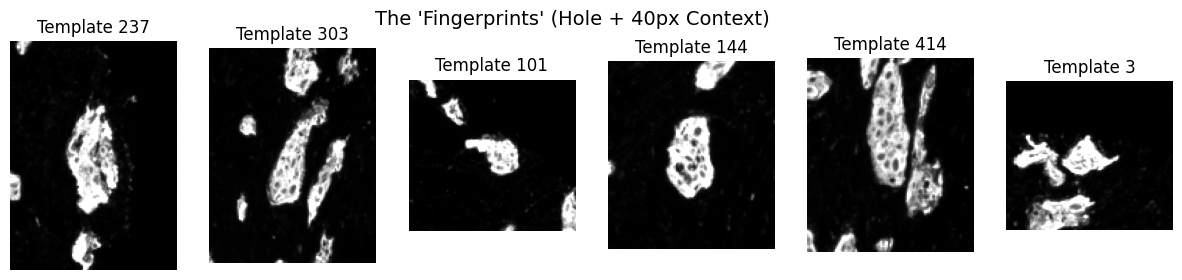

Tracking 6 templates...
Showing 0 stable context tracks.


In [20]:
import numpy as np
import cv2
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from glob import glob
import os

# --- CONFIGURATION ---
TEST_CORE = "Core_10" 
CK_INDEX = 6
DIAMETER = 30 
MIN_AREA = 100
MAX_AREA = 4000

# THE KEY CHANGE: Massive Context
# We don't just crop the hole. We crop the hole + 40 pixels of tissue in every direction.
# This captures the unique "fingerprint" of the stroma around the gland.
CONTEXT_PADDING = 40 
SEARCH_RADIUS = 100

# --- 1. LOAD & NORMALIZE (Standard) ---
def load_volume(core_id):
    core_folder = os.path.join(INPUT_ROOT, core_id)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None

    raw_stack = []
    print(f"Loading {len(slice_files)} slices for {core_id}...")
    for fpath in slice_files:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # Normalize to 8-bit (Crucial for Template Matching)
        if ck.dtype != np.uint8:
            p1, p99 = np.percentile(ck, (1, 99))
            ck = np.clip((ck - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
            ck = ck.astype(np.uint8)
        raw_stack.append(ck)
        
    mid_idx = len(raw_stack) // 2
    ref_h, ref_w = raw_stack[mid_idx].shape
    
    clean_stack = []
    for slice_img in raw_stack:
        if slice_img.shape != (ref_h, ref_w):
            resized = cv2.resize(slice_img, (ref_w, ref_h), interpolation=cv2.INTER_CUBIC)
            clean_stack.append(resized)
        else:
            clean_stack.append(slice_img)
    return np.array(clean_stack)

volume = load_volume(TEST_CORE)
mid_z = volume.shape[0] // 2
print(f"Volume loaded. Shape: {volume.shape}")


# --- 2. GENERATE "CONTEXT-RICH" TEMPLATES ---
print(f"Segmenting Anchor Slice (Z={mid_z}) to find holes...")
anchor_img = volume[mid_z, :, :]
masks, _, _ = model.eval(anchor_img, diameter=DIAMETER, channels=[0,0], 
                         flow_threshold=0.9, cellprob_threshold=-1.0)

props = regionprops(masks)
valid_props = [p for p in props if MIN_AREA < p.area < MAX_AREA]
valid_props.sort(key=lambda x: x.area, reverse=True) 

templates = []
chosen_centers = []

print(f"Extracting templates with {CONTEXT_PADDING}px context padding...")

for p in valid_props:
    if len(templates) >= 6: break # Pick top 6
    
    y, x = p.centroid
    
    # Ensure they aren't duplicates
    if any(np.sqrt((y-cy)**2 + (x-cx)**2) < 60 for cy, cx in chosen_centers):
        continue

    # --- HERE IS THE TRICK ---
    # 1. Get the tight box of the hole
    minr, minc, maxr, maxc = p.bbox
    
    # 2. Expand it massively to get the "Context"
    y1 = max(0, minr - CONTEXT_PADDING)
    x1 = max(0, minc - CONTEXT_PADDING)
    y2 = min(volume.shape[1], maxr + CONTEXT_PADDING)
    x2 = min(volume.shape[2], maxc + CONTEXT_PADDING)
    
    # 3. Crop this larger area
    patch = anchor_img[y1:y2, x1:x2]
    
    templates.append({
        'id': p.label,
        'image': patch,
        'orig_y': y,
        'orig_x': x,
        'h': patch.shape[0],
        'w': patch.shape[1]
    })
    chosen_centers.append((y, x))

# DEBUG: Show the templates so you can see the context
fig, axes = plt.subplots(1, len(templates), figsize=(15, 3))
for i, t in enumerate(templates):
    axes[i].imshow(t['image'], cmap='gray')
    axes[i].set_title(f"Template {t['id']}")
    axes[i].axis('off')
plt.suptitle(f"The 'Fingerprints' (Hole + {CONTEXT_PADDING}px Context)", fontsize=14)
plt.show()


# --- 3. RUN GATED TRACKING (No Updates = No Drift) ---
# We use the STATIC template. Because it includes so much context, 
# it is robust enough to handle small shape changes without needing updates.
print(f"Tracking {len(templates)} templates...")

tracker_results = {t['id']: [] for t in templates}

for t in templates:
    last_x, last_y = t['orig_x'], t['orig_y']
    
    # Track Forward
    for z in range(mid_z, volume.shape[0]):
        full_slice = volume[z, :, :]
        
        # Define Search ROI (Local Window)
        roi_y1 = int(max(0, last_y - SEARCH_RADIUS))
        roi_y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + t['h']))
        roi_x1 = int(max(0, last_x - SEARCH_RADIUS))
        roi_x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + t['w']))
        
        roi = full_slice[roi_y1:roi_y2, roi_x1:roi_x2]
        
        if roi.shape[0] >= t['h'] and roi.shape[1] >= t['w']:
            res = cv2.matchTemplate(roi, t['image'], cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            
            local_x, local_y = max_loc
            global_x = roi_x1 + local_x + t['w'] // 2
            global_y = roi_y1 + local_y + t['h'] // 2
            
            tracker_results[t['id']].append({'z': z, 'x': global_x, 'y': global_y, 'score': max_val})
            last_x, last_y = global_x, global_y # Update search center

    # Track Backward
    last_x, last_y = t['orig_x'], t['orig_y']
    for z in range(mid_z - 1, -1, -1):
        full_slice = volume[z, :, :]
        
        roi_y1 = int(max(0, last_y - SEARCH_RADIUS))
        roi_y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + t['h']))
        roi_x1 = int(max(0, last_x - SEARCH_RADIUS))
        roi_x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + t['w']))
        roi = full_slice[roi_y1:roi_y2, roi_x1:roi_x2]
        
        if roi.shape[0] >= t['h'] and roi.shape[1] >= t['w']:
            res = cv2.matchTemplate(roi, t['image'], cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            
            local_x, local_y = max_loc
            global_x = roi_x1 + local_x + t['w'] // 2
            global_y = roi_y1 + local_y + t['h'] // 2
            
            tracker_results[t['id']].append({'z': z, 'x': global_x, 'y': global_y, 'score': max_val})
            last_x, last_y = global_x, global_y


# --- 4. VISUALIZATION ---
# Filter poor tracks
final_tracks = []
for tid, tracks in tracker_results.items():
    df = pd.DataFrame(tracks).sort_values('z')
    if df['score'].mean() > 0.5: # Quality Threshold
        final_tracks.append((tid, df))

print(f"Showing {len(final_tracks)} stable context tracks.")

if final_tracks:
    CROP = 80
    fig, axes = plt.subplots(len(final_tracks), volume.shape[0], 
                             figsize=(20, 2.5 * len(final_tracks)), squeeze=False)
    
    for i, (tid, df) in enumerate(final_tracks):
        df = df.set_index('z')
        for z in range(volume.shape[0]):
            ax = axes[i, z]
            ax.axis('off')
            
            if z in df.index:
                cx, cy = int(df.loc[z, 'x']), int(df.loc[z, 'y'])
                score = df.loc[z, 'score']
                color = 'lime' if score > 0.6 else 'red'
                
                y1, y2 = max(0, cy-CROP), min(volume.shape[1], cy+CROP)
                x1, x2 = max(0, cx-CROP), min(volume.shape[2], cx+CROP)
                
                if y2 > y1 and x2 > x1:
                    ax.imshow(volume[z, y1:y2, x1:x2], cmap='gray')
                    ax.plot(cx - x1, cy - y1, '+', color=color, markersize=12, markeredgewidth=2)
                
                if z == 0: ax.set_title(f"ID {tid}", fontsize=12, color='blue', loc='left')
            else:
                ax.text(0.5, 0.5, "LOST", ha='center', color='red')

    plt.suptitle("Context-Aware Tracking (Static Template with Padding)", fontsize=16)
    plt.tight_layout()
    plt.show()

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Volume loaded. Shape: (20, 1512, 1512)
Segmenting Anchor Slice (Z=10)...
Tracking 6 templates with Radius 800...

--- SCORE REPORT ---
Lumen 237: Avg Score=0.69, Min Score=0.56
Lumen 303: Avg Score=0.54, Min Score=0.43
Lumen 101: Avg Score=0.55, Min Score=0.45
Lumen 144: Avg Score=0.71, Min Score=0.55
Lumen 414: Avg Score=0.56, Min Score=0.47
Lumen 3: Avg Score=0.63, Min Score=0.50


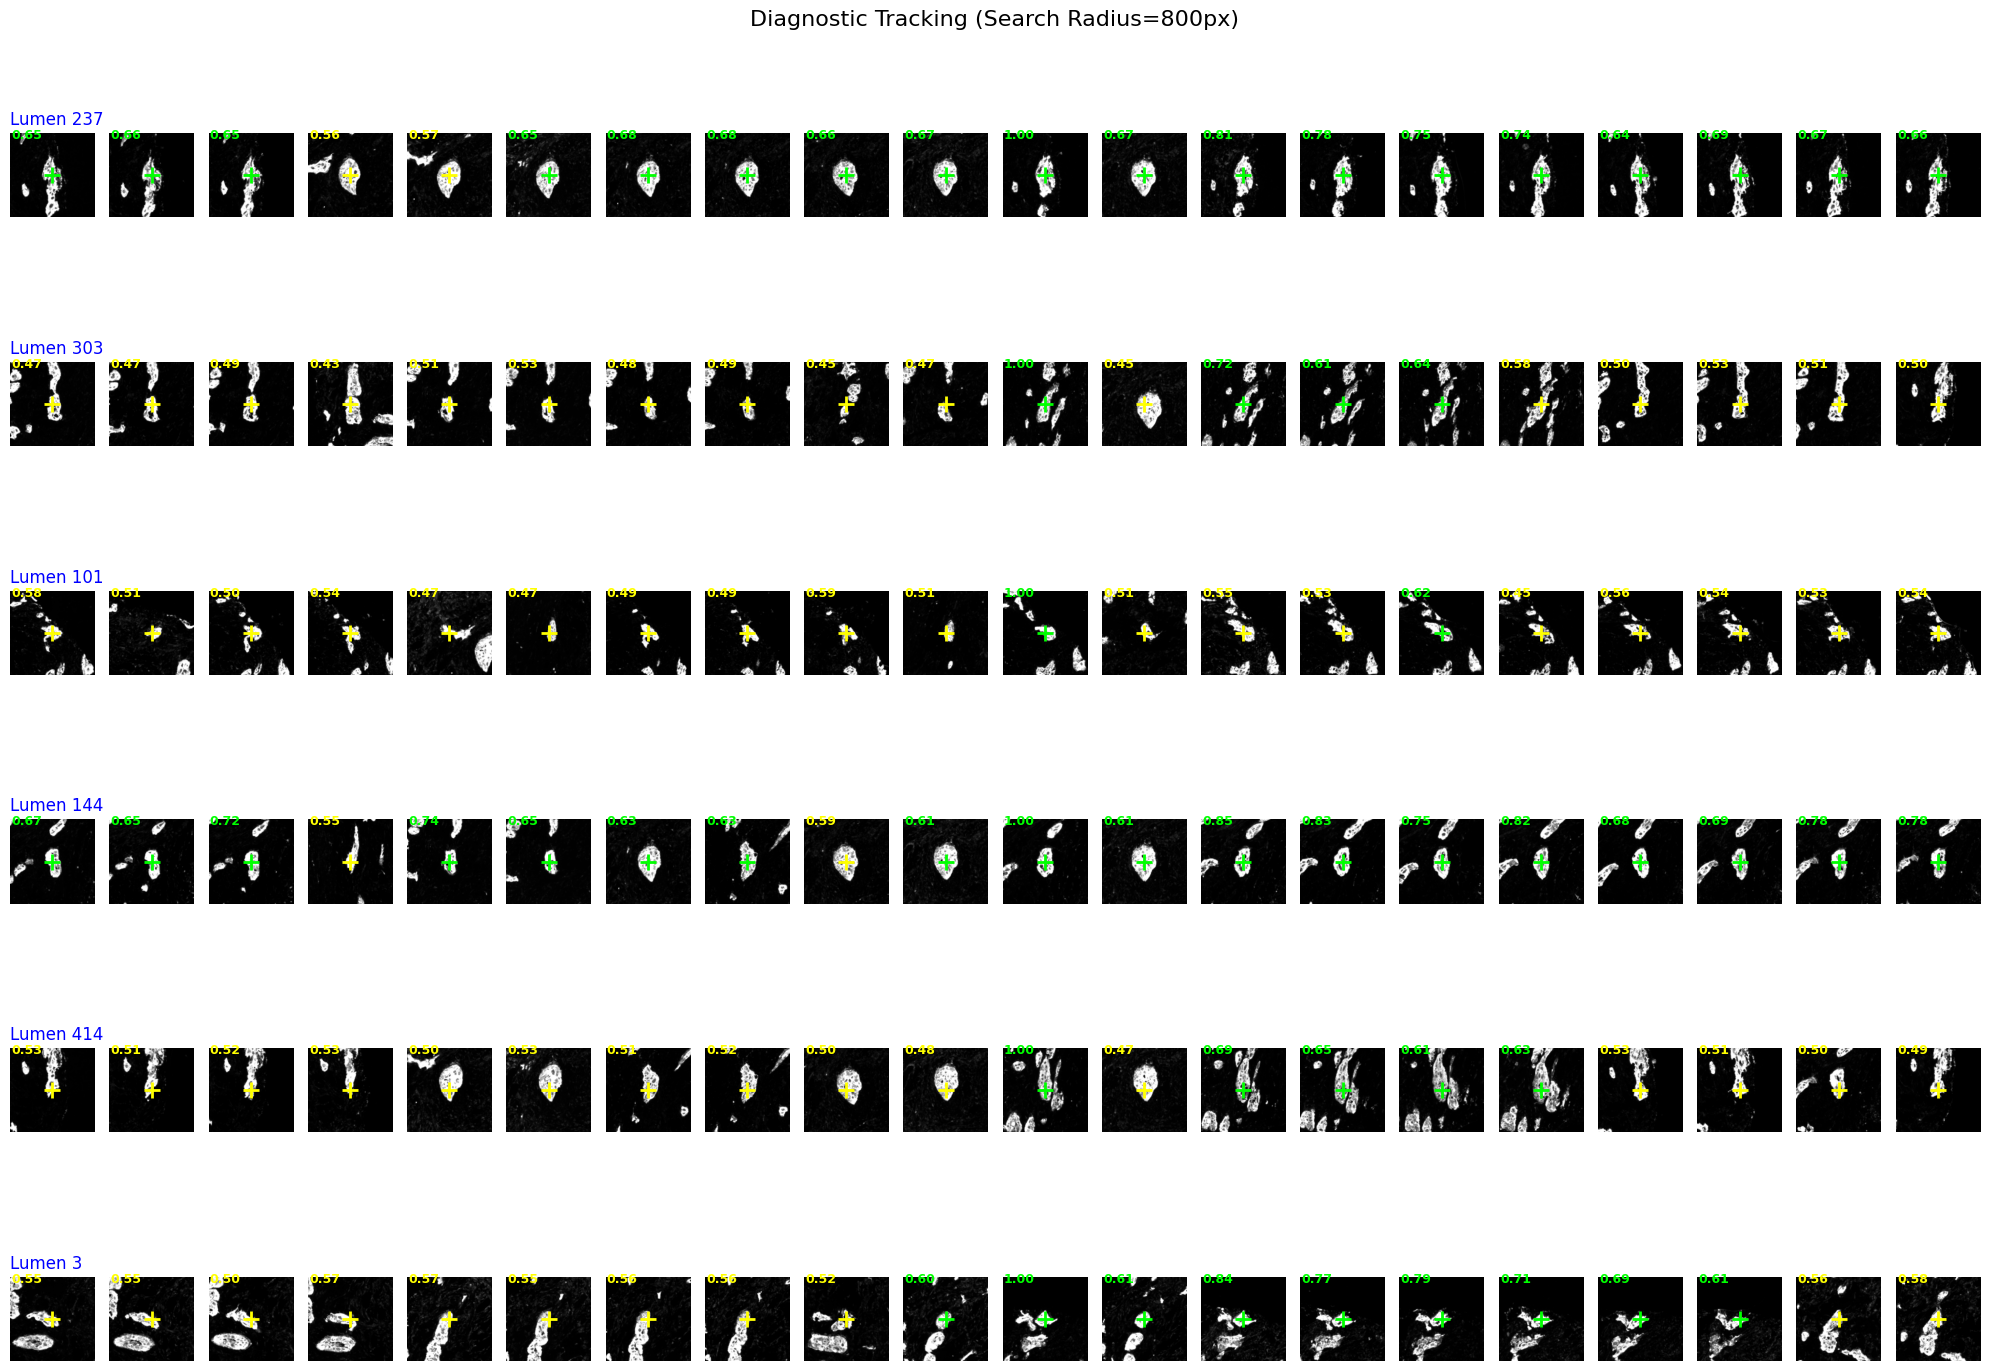

In [21]:
import numpy as np
import cv2
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from glob import glob
import os

# --- CONFIGURATION ---
TEST_CORE = "Core_10" 
CK_INDEX = 6
DIAMETER = 30 
MIN_AREA = 100
MAX_AREA = 4000

# FIX 1: Increase Context & Search Radius
CONTEXT_PADDING = 40 
SEARCH_RADIUS = 800   # Increased to handle your 678px drift

# --- LOAD & NORMALIZE ---
def load_volume(core_id):
    core_folder = os.path.join(INPUT_ROOT, core_id)
    slice_files = sorted(glob(os.path.join(core_folder, "*.ome.tif")))
    if not slice_files: return None

    raw_stack = []
    for fpath in slice_files:
        img = tifffile.imread(fpath)
        if img.shape[0] < 20: ck = img[CK_INDEX, :, :]
        else: ck = img[:, :, CK_INDEX]
        
        # Normalize to 8-bit
        if ck.dtype != np.uint8:
            p1, p99 = np.percentile(ck, (1, 99))
            ck = np.clip((ck - p1) / (p99 - p1 + 1e-5), 0, 1) * 255
            ck = ck.astype(np.uint8)
        raw_stack.append(ck)
        
    mid_idx = len(raw_stack) // 2
    ref_h, ref_w = raw_stack[mid_idx].shape
    
    clean_stack = []
    for slice_img in raw_stack:
        if slice_img.shape != (ref_h, ref_w):
            resized = cv2.resize(slice_img, (ref_w, ref_h), interpolation=cv2.INTER_CUBIC)
            clean_stack.append(resized)
        else:
            clean_stack.append(slice_img)
    return np.array(clean_stack)

volume = load_volume(TEST_CORE)
mid_z = volume.shape[0] // 2
print(f"Volume loaded. Shape: {volume.shape}")

# --- EXTRACT TEMPLATES ---
print(f"Segmenting Anchor Slice (Z={mid_z})...")
anchor_img = volume[mid_z, :, :]
masks, _, _ = model.eval(anchor_img, diameter=DIAMETER, channels=[0,0], 
                         flow_threshold=0.9, cellprob_threshold=-1.0)

props = regionprops(masks)
valid_props = [p for p in props if MIN_AREA < p.area < MAX_AREA]
valid_props.sort(key=lambda x: x.area, reverse=True) 

templates = []
chosen_centers = []

for p in valid_props:
    if len(templates) >= 6: break
    
    y, x = p.centroid
    if any(np.sqrt((y-cy)**2 + (x-cx)**2) < 60 for cy, cx in chosen_centers):
        continue

    minr, minc, maxr, maxc = p.bbox
    y1 = max(0, minr - CONTEXT_PADDING)
    x1 = max(0, minc - CONTEXT_PADDING)
    y2 = min(volume.shape[1], maxr + CONTEXT_PADDING)
    x2 = min(volume.shape[2], maxc + CONTEXT_PADDING)
    
    patch = anchor_img[y1:y2, x1:x2]
    
    templates.append({
        'id': p.label,
        'image': patch,
        'orig_y': y,
        'orig_x': x,
        'h': patch.shape[0],
        'w': patch.shape[1]
    })
    chosen_centers.append((y, x))

# --- RUN TRACKING (DIAGNOSTIC MODE) ---
print(f"Tracking {len(templates)} templates with Radius {SEARCH_RADIUS}...")

tracker_results = {t['id']: [] for t in templates}

for t in templates:
    last_x, last_y = t['orig_x'], t['orig_y']
    
    # Track Forward
    for z in range(mid_z, volume.shape[0]):
        full_slice = volume[z, :, :]
        
        roi_y1 = int(max(0, last_y - SEARCH_RADIUS))
        roi_y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + t['h']))
        roi_x1 = int(max(0, last_x - SEARCH_RADIUS))
        roi_x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + t['w']))
        
        roi = full_slice[roi_y1:roi_y2, roi_x1:roi_x2]
        
        if roi.shape[0] >= t['h'] and roi.shape[1] >= t['w']:
            res = cv2.matchTemplate(roi, t['image'], cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            
            global_x = roi_x1 + max_loc[0] + t['w'] // 2
            global_y = roi_y1 + max_loc[1] + t['h'] // 2
            
            tracker_results[t['id']].append({'z': z, 'x': global_x, 'y': global_y, 'score': max_val})
            last_x, last_y = global_x, global_y
            
    # Track Backward
    last_x, last_y = t['orig_x'], t['orig_y']
    for z in range(mid_z - 1, -1, -1):
        full_slice = volume[z, :, :]
        
        roi_y1 = int(max(0, last_y - SEARCH_RADIUS))
        roi_y2 = int(min(volume.shape[1], last_y + SEARCH_RADIUS + t['h']))
        roi_x1 = int(max(0, last_x - SEARCH_RADIUS))
        roi_x2 = int(min(volume.shape[2], last_x + SEARCH_RADIUS + t['w']))
        roi = full_slice[roi_y1:roi_y2, roi_x1:roi_x2]
        
        if roi.shape[0] >= t['h'] and roi.shape[1] >= t['w']:
            res = cv2.matchTemplate(roi, t['image'], cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            
            global_x = roi_x1 + max_loc[0] + t['w'] // 2
            global_y = roi_y1 + max_loc[1] + t['h'] // 2
            
            tracker_results[t['id']].append({'z': z, 'x': global_x, 'y': global_y, 'score': max_val})
            last_x, last_y = global_x, global_y

# --- VISUALIZATION (SHOW ALL) ---
print("\n--- SCORE REPORT ---")
final_tracks = []
for tid, tracks in tracker_results.items():
    df = pd.DataFrame(tracks).sort_values('z')
    avg_score = df['score'].mean()
    min_score = df['score'].min()
    print(f"Lumen {tid}: Avg Score={avg_score:.2f}, Min Score={min_score:.2f}")
    
    # FIX 2: Add everything, even if score is bad
    final_tracks.append((tid, df))

if final_tracks:
    CROP = 80
    fig, axes = plt.subplots(len(final_tracks), volume.shape[0], 
                             figsize=(20, 2.5 * len(final_tracks)), squeeze=False)
    
    for i, (tid, df) in enumerate(final_tracks):
        df = df.set_index('z')
        for z in range(volume.shape[0]):
            ax = axes[i, z]
            ax.axis('off')
            
            if z in df.index:
                cx, cy = int(df.loc[z, 'x']), int(df.loc[z, 'y'])
                score = df.loc[z, 'score']
                
                # Color code: Green=Good, Yellow=Ok, Red=Bad
                if score > 0.6: color = 'lime'
                elif score > 0.4: color = 'yellow'
                else: color = 'red'
                
                y1, y2 = max(0, cy-CROP), min(volume.shape[1], cy+CROP)
                x1, x2 = max(0, cx-CROP), min(volume.shape[2], cx+CROP)
                
                if y2 > y1 and x2 > x1:
                    ax.imshow(volume[z, y1:y2, x1:x2], cmap='gray')
                    ax.plot(cx - x1, cy - y1, '+', color=color, markersize=12, markeredgewidth=2)
                    ax.text(2, 10, f"{score:.2f}", color=color, fontsize=9, fontweight='bold')
                
                if z == 0: ax.set_title(f"Lumen {tid}", fontsize=12, color='blue', loc='left')

    plt.suptitle(f"Diagnostic Tracking (Search Radius={SEARCH_RADIUS}px)", fontsize=16)
    plt.tight_layout()
    plt.show()